In [1]:
import pandas as pd

dados = pd.read_csv('day.csv')
dados.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [2]:
import matplotlib.pyplot as plt

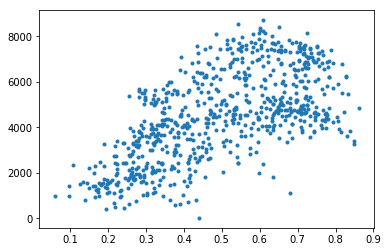

In [3]:
plt.plot(dados['temp'],dados['cnt'],'.')

In [4]:
import numpy as np

In [5]:
y = np.asarray(dados['cnt']) #Alvo

In [6]:
X = np.asarray(dados[['weathersit','atemp']])
print(X)

[[2.       0.363625]
 [2.       0.353739]
 [1.       0.189405]
 ...
 [2.       0.2424  ]
 [1.       0.2317  ]
 [2.       0.223487]]


In [7]:
#Escalar

X = X/np.amax(X,axis=0)
print(X)

[[0.66666667 0.43242565]
 [0.66666667 0.42066914]
 [0.33333333 0.22524188]
 ...
 [0.66666667 0.28826395]
 [0.33333333 0.27553942]
 [0.66666667 0.26577246]]


In [8]:
ymax=np.amax(y)
y = y/ymax

In [9]:
arquitetura = [
    {"dim_entrada": 2, "dim_saida": 25, "ativacao": "relu"},
    {"dim_entrada": 25, "dim_saida": 1, "ativacao": "sigmoid"},
]

In [10]:
def inicia_camadas(arquitetura, seed = 99):
    # inicia os valores aleatórios
    np.random.seed(seed)
    # numero de camadas da rede neural
    numero_de_camadas = len(arquitetura)
    # inicia armazenamento de parametros
    valores_parametros = {}
    
    # itera nas camadas da rede
    for indice, camada in enumerate(arquitetura):
        
        indice_camada = indice + 1
        
        # extrai o numero de nodos nas camadas
        tamanho_camada_entrada = camada["dim_entrada"]
        tamanho_camada_saida = camada["dim_saida"]
        
        # inicia os valores na matriz de pesos P
        # e o vetor de bias b
        valores_parametros['P' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, tamanho_camada_entrada) * 0.1
        valores_parametros['b' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, 1) * 0.1
        
    return valores_parametros

In [11]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_retro(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_retro(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [12]:
def propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, ativacao="relu"):
    # cálculo da entrada para a função de ativação
    Z_atual = np.dot(Pesos_atual, Ativado_anterior) + b_atual
    
    # selecção da função de ativação
    if ativacao is "relu":
        func_ativacao = relu
    elif ativacao is "sigmoid":
        func_ativacao = sigmoid
    else:
        raise Exception('Ainda não implementamos essa funcao')
        
    # retorna a ativação calculada A_atual e a matriz intermediária Z
    return func_ativacao(Z_atual), Z_atual

In [13]:
def propaga_total(X, valores_parametros, arquitetura):
    # memoria temporaria para a retropropagacao
    memoria = {}
    # O vetor X é a ativação para a camada 0 
    Ativado_atual = X
    
    # iterações para as camadas
    for indice, camada in enumerate(arquitetura):
        # a numeração das camadas começa de 1
        indice_camada = indice + 1
        # utiliza a ativação da iteração anterior
        Ativado_anterior = Ativado_atual
        
        # extrai a função de ativação para a camada atual
        func_ativacao_atual = camada["ativacao"]
        # extrai os pesos da camada atual
        Pesos_atual = valores_parametros["P" + str(indice_camada)]
        # extrai o bias para a camada atual
        b_atual = valores_parametros["b" + str(indice_camada)]
        # cálculo da ativação para a camada atual
        Ativado_atual, Z_atual = propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, func_ativacao_atual)
        
        # salca os valores calculados na memória
        memoria["A" + str(indice)] = Ativado_anterior
        memoria["Z" + str(indice_camada)] = Z_atual
       
    # retorna o vetor predito e um dicionário contendo os valores intermediários
    return Ativado_atual, memoria

In [14]:
def valor_de_custo(Y_predito, Y):
    # numero_de_exemplos
    m = Y_predito.shape[1]
    
    custo = -1 / m * (np.dot(Y, np.log(Y_predito).T) + np.dot(1 - Y, np.log(1 - Y_predito).T))
    return np.squeeze(custo)

In [15]:
def retropropagacao_uma_camada(dA_atual, Pesos_atual, b_atual, Z_atual, A_anterior, ativacao="relu"):
    # number of examples
    m = A_anterior.shape[1]
    
    # seleção função de ativação
    if ativacao is "relu":
        func_ativacao_retro = relu_retro
    elif ativacao is "sigmoid":
        func_ativacao_retro = sigmoid_retro
    else:
        raise Exception('Ainda não implementamos essa funcao')
    
    # derivada da função de ativação
    dZ_atual = func_ativacao_retro(dA_atual, Z_atual)
    
    # derivada da matriz de Pesos
    dP_atual = np.dot(dZ_atual, A_anterior.T) / m
    # derivada do vetor b
    db_atual = np.sum(dZ_atual, axis=1, keepdims=True) / m
    # derivada da matriz A_anterior
    dA_anterior = np.dot(Pesos_atual.T, dZ_atual)

    return dA_anterior, dP_atual, db_atual

In [16]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
    gradientes = {}
    
    # numero de exemplos
    m = Y.shape[1]
    # para garantir que os dois vetores tenham a mesma dimensão
    Y = Y.reshape(Y_predito.shape)
    
    # inicia o algoritmo de gradiente decendente
    dA_anterior = - (np.divide(Y, Y_predito) - np.divide(1 - Y, 1 - Y_predito));
    
    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        
        indice_camada_atual = indice_camada_anterior + 1
        # Função de ativação para a camada atual
        
        funcao_ativao_atual = camada["ativacao"]
        
        dA_atual = dA_anterior
        
        A_anterior = memoria["A" + str(indice_camada_anterior)]
        Z_atual = memoria["Z" + str(indice_camada_atual)]
        
        Pesos_atual = valores_parametros["P" + str(indice_camada_atual)]
        b_atual = valores_parametros["b" + str(indice_camada_atual)]
        
        dA_anterior, dP_atual, db_atual = retropropagacao_uma_camada(
            dA_atual, Pesos_atual, b_atual, Z_atual, A_anterior, funcao_ativao_atual)
        
        gradientes["dP" + str(indice_camada_atual)] = dP_atual
        gradientes["db" + str(indice_camada_atual)] = db_atual
    
    return gradientes

In [17]:
def atualiza(valores_parametros, gradidentes, arquitetura, taxa_aprendizagem):

    # iterações pelas camadas
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros["P" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["dP" + str(indice_camada)]        
        valores_parametros["b" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["db" + str(indice_camada)]

    return valores_parametros;

In [18]:
def treino(X, Y, arquitetura, epocas, taxa_aprendizagem):
    # Inicia os parâmetros da rede neural
    valores_parametros = inicia_camadas(arquitetura, 2)
    # Listas que vão guardar o progresso da aprendizagem da rede 
    historia_custo = []
   
    
    # Atualiza a cada época
    for i in range(epocas):
        # Propaga a rede - Foward propagation
        Y_predito, memoria = propaga_total(X, valores_parametros, arquitetura)
        
        # calcula as métricas e salva nas listas de historia
        custo = valor_de_custo(Y_predito, Y)
        historia_custo.append(custo)
        
        
        # Retropropagação - Backpropagation
        gradientes = retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura)
        # Atualiza os pesos
        valores_parametros = atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem)
        
        if(i % 50 == 0):
            
            print("Iteração: {:05} - custo: {:.5f} ".format(i, custo))
            
            
    return valores_parametros, historia_custo

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# number of samples in the data set
N_SAMPLES = 731
# ratio between training and test sets
TEST_SIZE = 0.1
#arquitetura = NN_ARCHITECTURE

In [21]:
y.shape

(731,)

In [22]:
X_treino = X
y_treino = y

In [23]:
# Treinamento
valores_parametros, historia_custo = treino(np.transpose(X_treino), np.transpose(y_treino.reshape((y_treino.shape[0], 1))), arquitetura, 10000, 0.01)

Iteração: 00000 - custo: 0.69332 
Iteração: 00050 - custo: 0.69304 
Iteração: 00100 - custo: 0.69282 
Iteração: 00150 - custo: 0.69262 
Iteração: 00200 - custo: 0.69244 
Iteração: 00250 - custo: 0.69229 
Iteração: 00300 - custo: 0.69213 
Iteração: 00350 - custo: 0.69196 
Iteração: 00400 - custo: 0.69179 
Iteração: 00450 - custo: 0.69161 
Iteração: 00500 - custo: 0.69144 
Iteração: 00550 - custo: 0.69128 
Iteração: 00600 - custo: 0.69115 
Iteração: 00650 - custo: 0.69102 
Iteração: 00700 - custo: 0.69090 
Iteração: 00750 - custo: 0.69078 
Iteração: 00800 - custo: 0.69067 
Iteração: 00850 - custo: 0.69055 
Iteração: 00900 - custo: 0.69043 
Iteração: 00950 - custo: 0.69031 
Iteração: 01000 - custo: 0.69019 
Iteração: 01050 - custo: 0.69007 
Iteração: 01100 - custo: 0.68995 
Iteração: 01150 - custo: 0.68983 
Iteração: 01200 - custo: 0.68970 
Iteração: 01250 - custo: 0.68958 
Iteração: 01300 - custo: 0.68945 
Iteração: 01350 - custo: 0.68932 
Iteração: 01400 - custo: 0.68919 
Iteração: 0145

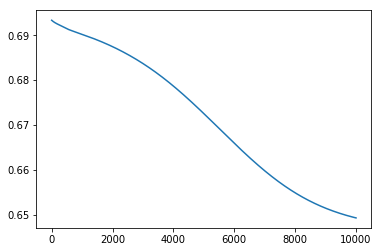

In [24]:
plt.plot(historia_custo)
plt.show()

In [25]:
# Previsão
Y_pred, _ = propaga_total(np.transpose(X), valores_parametros, arquitetura)

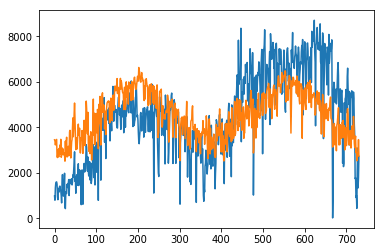

In [26]:
plt.plot(ymax*y)
plt.plot(ymax*Y_pred.reshape([-1,1]))
plt.show()